# Kalman Filter

In [23]:
import numpy as np
import scipy.optimize as optimize
import scipy as sc
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling

/Users/Amit/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/Amit/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Amit/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Amit/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
   

In [2]:
def KalmanFilterForecast(R, k):
    r = 1.91*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
        
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star = optimize.fmin(objective,param0)
    print(params_star)
    #params_star = optimize.minimize(objective,param0,method='CG')
    #params_star = params_star.values()[5]
    #print(params_star)
    u_smooth = KalmanSmoother(R, k, params_star)
#     Z = np.array(params_star[0])
#     H = np.exp(params_star[1]);
#     T = np.array(params_star[2])
#     Q = np.exp(params_star[3]);
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    return price_tplus1,u_tplus1,u_smooth,params_star

In [3]:
i = 0
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
#         Z = np.array(params[0])
#         H = np.array(np.exp(params[1]))
#         T = np.array(params[2])
#         Q = np.array(np.exp(params[3]))
        Z = np.array(2/(1+np.exp(-params[0]))-1) #sample space
        H = np.array(np.exp(params[1]))  #variance of y
        T = np.array(2/(1+np.exp(-params[2]))-1)  #mean
        Q = np.array(np.exp(params[3]))  #0.5 variance of y
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in range(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]       
    return Likelihood, varargout

In [4]:
 T = np.array(2/(1+np.exp(-5.12))-1)
T

array(0.98811896)

In [5]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(range(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [6]:
data = pd.read_excel("../0.Data/forex.xlsx")
data.set_index(data.observation_date)
data=data.dropna()
R=data['DEXUSUK'].values
#R=np.matrix(R)
k=1


In [7]:
price_tplus1,u_tplus1,u_smooth,params_star = KalmanFilterForecast(R, k)
#KalmanFilterForecast(R, k)


Optimization terminated successfully.
         Current function value: -1859.029424
         Iterations: 181
         Function evaluations: 386
[-495.92827179  -39.24853112  219.21244074   -7.99374167]
T*u_smooth[-1] is -1.6511999999999996; Z*u_tplus1 is 1.6588676325088367


In [8]:
print(price_tplus1)

1.6588676329116565


In [9]:
print(u_tplus1)

-1.6588676325088367


In [10]:
u_smooth=-u_smooth
print(u_smooth)

[1.7588 1.7566 1.7697 1.7645 1.7645 1.7643 1.7612 1.7715 1.7628 1.7618
 1.7663 1.7842 1.7885 1.7874 1.783  1.7733 1.7688 1.782  1.7781 1.7807
 1.7626 1.7462 1.7444 1.7405 1.7411 1.7454 1.7438 1.7343 1.7354 1.7403
 1.7447 1.7425 1.7522 1.7448 1.7409 1.7539 1.7473 1.7493 1.7531 1.7492
 1.7362 1.7359 1.7366 1.7256 1.731  1.7479 1.746  1.7552 1.7567 1.7563
 1.7459 1.7483 1.7367 1.7427 1.747  1.7497 1.7356 1.7448 1.7393 1.7389
 1.7559 1.7497 1.7504 1.7407 1.7405 1.7467 1.7508 1.7529 1.751  1.7716
 1.7762 1.7895 1.7801 1.7817 1.7839 1.7876 1.7897 1.8011 1.822  1.8286
 1.8397 1.8446 1.8485 1.8588 1.8584 1.8632 1.8648 1.8842 1.8911 1.8836
 1.8819 1.882  1.8878 1.8755 1.8861 1.8809 1.8719 1.8566 1.8825 1.8732
 1.8686 1.8817 1.8786 1.8608 1.8585 1.8425 1.8426 1.844  1.8398 1.8491
 1.8477 1.8484 1.8401 1.8399 1.846  1.8306 1.8204 1.819  1.8237 1.8159
 1.8108 1.8491 1.841  1.8342 1.8376 1.8513 1.842  1.8431 1.8347 1.8404
 1.8364 1.8203 1.8271 1.8377 1.8495 1.8586 1.8492 1.8407 1.8474 1.8627
 1.864

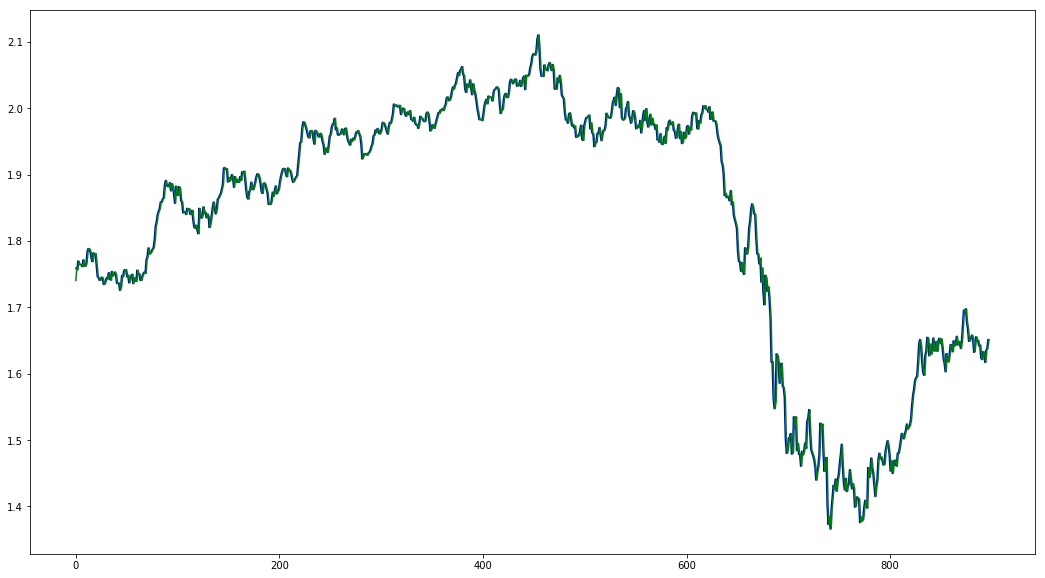

In [11]:
fig = plt.figure(figsize=(18,10))
#plt.plot(price_tplus1,'y',label = "price_tplus1")
#plt.plot(\,'r',label = "u_tplus1")
plt.plot(u_smooth,'b',label = "u_smooth")
plt.plot(R,'g',label = "price")
plt.show()


# Trading Strategy using Bollinger Band

In [12]:
df = pd.DataFrame(u_smooth)
df.columns = ['Y_hat_Kalman']
df.set_index = data.index
df.head()

,Y_hat_Kalman
0,1.7588
1,1.7566
2,1.7697
3,1.7645
4,1.7645


In [13]:
long_MA = df['Y_hat_Kalman'].rolling(window=20).mean()
df['Long_Moving_Avg'] = long_MA

In [14]:
short_MA = df['Y_hat_Kalman'].rolling(window=5).mean()
df['Short_Moving_Avg'] = long_MA

In [15]:
long_std= df['Y_hat_Kalman'].rolling(window=20).std()
df['Long_std'] = long_std

In [16]:
long_upper_band = ((long_MA) + (long_std)*0.75)
df['Long_Upper_Band'] = long_upper_band

In [17]:
long_lower_band = ((long_MA) - (long_std)*0.75)
df['Long_Lower_Band'] = long_lower_band

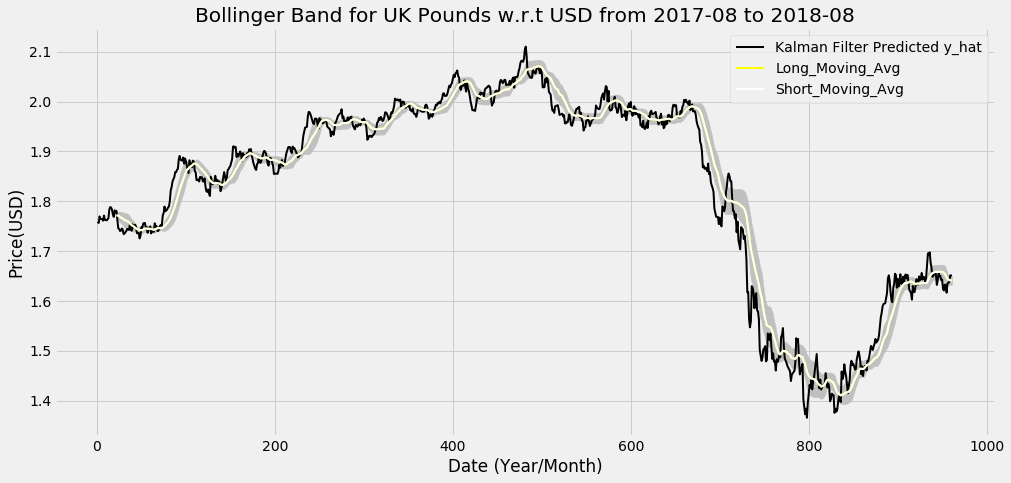

In [18]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = data.index
ax.fill_between(x_axis, df['Long_Upper_Band'], df['Long_Lower_Band'], color='silver')
ax.plot(x_axis, df['Y_hat_Kalman'], color='black', lw=2, label = 'Kalman Filter Predicted y_hat')
ax.plot(x_axis, df['Long_Moving_Avg'], color='yellow', lw=2)
ax.plot(x_axis, df['Short_Moving_Avg'], color='white', lw=2)

ax.set_title('Bollinger Band for UK Pounds w.r.t USD from 2017-08 to 2018-08')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

# Trading Strategy using Double Cross-Over

<Figure size 1080x504 with 0 Axes>

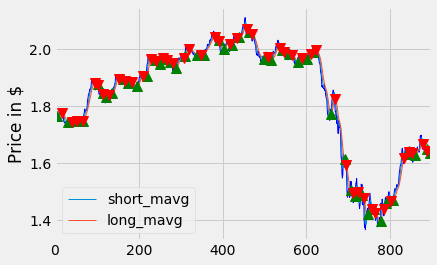

<Figure size 1080x504 with 0 Axes>

In [21]:
ig = plt.figure(figsize=(15,7))
short_window = 5
long_window =10
#df = df.set_index(pd.DatetimeIndex(df['observation_date']))
# Initialize the `signals` DataFrame with the `signal` column
#lowest_Y_hat_bst_avg = lowest_Y_hat_bst_avg.set_index(pd.DatetimeIndex(lowest_Y_hat_bst_avg.index))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = df['Y_hat_Kalman'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = df['Y_hat_Kalman'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]
                                           > signals['long_mavg'][short_window:], 1.0, 0.0)

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
#print(signals)

# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['Y_hat_Kalman'].plot(ax=ax1, color='b', lw=1.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1,lw=1.)
listLongShort = ["No data"]

for i in range(1, len(signals)):
    # If the MACD crosses the signal line upward
   if signals.long_mavg[i] > df['Y_hat_Kalman'][i] and signals.long_mavg[i - 1] <= df['Y_hat_Kalman'][i - 1]:
       listLongShort.append("BUY")
    # The other way around
   elif signals.short_mavg[i] < df['Y_hat_Kalman'][i] and signals.short_mavg[i - 1] >= df['Y_hat_Kalman'][i - 1]:
       listLongShort.append("SELL")
    # Do nothing if not crossed
   else:
       listLongShort.append("HOLD")

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index,
        signals.short_mavg[signals.positions == 1.0],
        '^', markersize=10, color='g')

# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index,
        signals.short_mavg[signals.positions == -1.0],
        'v', markersize=10, color='r')

fig = plt.figure(figsize=(15,7))
plt.show()

In [24]:
signals['Advice'] = listLongShort
pandas_profiling.ProfileReport(signals)

Number of variables,5
Number of observations,898
Total Missing (%),0.0%
Total size in memory,35.2 KiB
Average record size in memory,40.1 B
Numeric,2
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,1


# Postions Taken in Forex Market:
- -1 = SELL
- 1 = BUY
- 0 = HOLD

In [25]:
signals['positions'].value_counts()

 0.0    802
 1.0     48
-1.0     47
Name: positions, dtype: int64

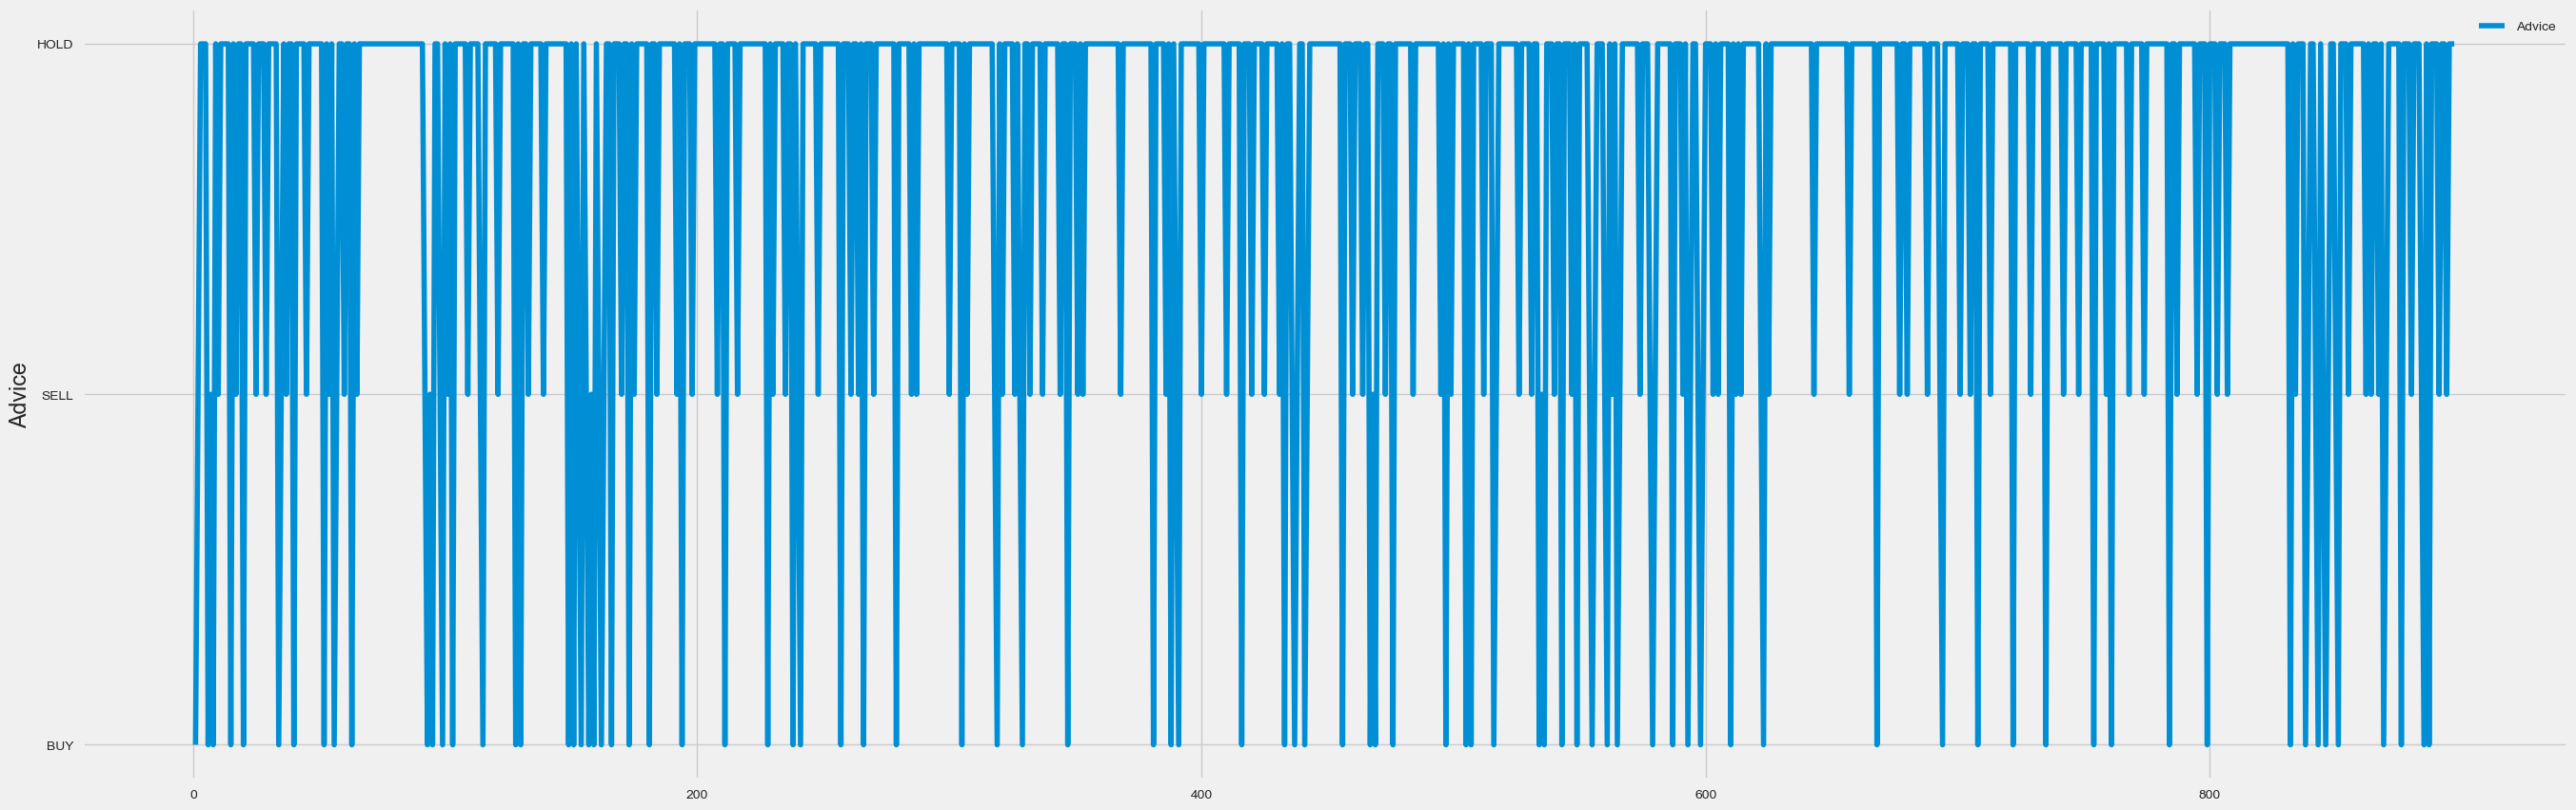

In [26]:
import matplotlib.pyplot as plt
signals = signals[signals.Advice != 'No data']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)



y_axis=signals.Advice

ax.plot(y_axis)


#ax.set_xlabel('Date (Year)')
ax.set_ylabel('Advice')
ax.legend()
plt.show();

# Calculating Risk Metrics

In [27]:
sell=[]
buy=[]
for i in range(1,len(signals)):
   if signals['positions'].iloc[i]==-1:
       sell.append(signals['long_mavg'].iloc[i])
   elif signals['positions'].iloc[i]==1:
       buy.append(signals['short_mavg'].iloc[i])

In [28]:
profit_loss=[]
for i in range(1,len(sell)):
   profit_loss.append(sell[i]-buy[i])

profit_loss

[0.0032599999999993745,
 -0.0006900000000005235,
 0.0008600000000009711,
 0.13412000000000024,
 -0.002829999999998778,
 -0.0015999999999987136,
 0.010780000000001566,
 0.0524200000000008,
 -0.0027399999999988545,
 0.006860000000000754,
 0.03250000000000064,
 0.05743000000000076,
 -0.00370999999999877,
 0.021330000000000293,
 -0.0024599999999994626,
 -0.0010199999999991327,
 0.036690000000001,
 0.026400000000000867,
 0.0010100000000003995,
 0.06993000000000049,
 -0.0008399999999992858,
 0.019910000000001205,
 0.024600000000001288,
 0.037570000000002324,
 -0.0027099999999977697,
 0.013340000000002572,
 0.04962000000000244,
 -0.007499999999997842,
 0.0028200000000033754,
 0.0175200000000022,
 0.017110000000003733,
 0.007570000000003629,
 0.05338000000000376,
 -0.018619999999995196,
 -0.005559999999996457,
 0.017070000000003693,
 -0.004099999999996662,
 0.028750000000003828,
 -0.00612999999999686,
 0.04342000000000246,
 0.015590000000001769,
 0.1501700000000019,
 0.007100000000002993,
 -0.

In [29]:
profit=[]
loss=[]
for i in range(1,len(profit_loss)):
   if profit_loss[i]>0:
       profit.append(profit_loss[i])
   elif profit_loss[i]<0:
       loss.append(profit_loss[i])

In [30]:
GrossLoss=sum(loss)
GrossLoss

-0.06563999999996883

In [31]:
GrossProfit=sum(profit)
NetProfit=GrossProfit+GrossLoss
NetProfit

0.9309800000000854

In [32]:
ProfitFactor=GrossProfit/GrossLoss    #benchmarking
ProfitFactor

-15.183120048758797

In [36]:
principal = df['Y_hat_Kalman'].iloc[0]
totalreturn = GrossProfit/principal                  #the profit after the principal amount eg:salary
print('%.2f%%' % (totalreturn*100))

56.66%


In [37]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='tatiya.s', api_key='e9oDZ5ph3cbxFs01p37B')
trace = go.Table(
   header=dict(values=['Risk Metrics', 'Values']),
   cells=dict(values=[['GrossProfit', 'GrossLoss', 'NetProfit','Profit Factor','TotalReturn'],
                      [GrossProfit, GrossLoss, NetProfit,ProfitFactor,(totalreturn*100)]]))


data = [trace]
py.iplot(data, filename = 'basic_table')